<a href="https://colab.research.google.com/github/AI-Unibo-Projects/Deep-Learning-Project/blob/4_model/FaceGenerator_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions


<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

## Enabling and testing the TPU

We'll check that we can connect to the TPU:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.keras.backend.clear_session()  # For easy reset of notebook state."""
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
    
config = tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0-rc3
Running on TPU  ['10.37.35.146:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.37.35.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.37.35.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers
import os
from PIL import Image
import time

from IPython import display

In [3]:
GENERATE_RES = 2 # Generation resolution factor (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
EPOCHS = 10000
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
BUFFER_SIZE = 60000

IMAGE_SIZE = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.



## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://celeba-public/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_attribute_list(example):
  features = {
      "names": tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, features)
  attributes_names = example['names']
  return attributes_names

def get_names():
  record = tf.data.TFRecordDataset('gs://celeba-test/attribute_list.tfrec')
  attributes = record.map(parse_attribute_list)
  att_names = next(attributes.as_numpy_iterator()).decode("utf-8")
  att_names_list = [elem.strip()[1:-1] for elem in att_names.split(',')]
  return att_names_list

att_names_list = get_names()


feature_dict = {
      "filename": tf.io.FixedLenFeature([], tf.string),
      "height": tf.io.FixedLenFeature([], tf.int64),
      "width": tf.io.FixedLenFeature([], tf.int64),
      "depth": tf.io.FixedLenFeature([], tf.int64),
      "image": tf.io.FixedLenFeature([], tf.string),
  }

attributes_dict = dict(zip(att_names_list, [tf.io.FixedLenFeature([], tf.int64) for elem in att_names_list]))

feature_dict.update(attributes_dict) 

def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  #filename = example['filename']
  width = tf.cast(example['width'],tf.int64)
  height = tf.cast(example['height'],tf.int64)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [height, width, 3])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], (IMAGE_SIZE[0], IMAGE_SIZE[1])) # crop and reshape the image 
  #attr_dict = {}
  #for name in att_names_list:
  #  attr_dict[name] = example[name]

  # return filename, image_tensor, attr_dict
  return image_tensor

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

dataset = load_dataset(filenames).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
print(type(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


Let's take a peek at the dataset we've created:

In [0]:
def display_images(images, n):
  plt.figure(figsize=(13,13))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, i+1)
    # turn off axis
    plt.axis('off')
    plt.imshow(images[i])
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(dataset, 100)

In [6]:
"""# Re-run this cell to show a new batch of images
name, images, attr = next(training_viz_iterator)
print('Image name {}\n'.format(name[0]))
for name in attr.keys():
  print('{}: {}\n'.format(name, attr[name][0]))
display_images(images, 10)"""

"# Re-run this cell to show a new batch of images\nname, images, attr = next(training_viz_iterator)\nprint('Image name {}\n'.format(name[0]))\nfor name in attr.keys():\n  print('{}: {}\n'.format(name, attr[name][0]))\ndisplay_images(images, 10)"

## Model


In [0]:
def build_generator(seed_size, channels):
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(layers.Reshape((4,4,256)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
    model.add(layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    # Final CNN layer
    model.add(layers.Conv2D(channels,kernel_size=3,padding="same"))
    model.add(layers.Activation("tanh"))

    return model

def build_discriminator(image_shape):
    model = tf.keras.models.Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [0]:
def build_generator():
  # Generator using Functional API

  # Input layer
  input_layer = layers.Input(shape=(100,))
  x = layers.Dense(8*8*256, use_bias=False)(input_layer) # input_shape is the noise seed
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Reshape input
  reshape = layers.Reshape((8, 8, 256))
  x = reshape(x)
  # assert reshape.output_shape == (None, 8, 8, 256) # Note: None is the batch size
  
  # First upscale layer
  conv2dtranspose_1 = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
  x = conv2dtranspose_1(x)
  # assert conv2dtranspose_1.output_shape == (None, 8, 8, 128)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Second upscale layer
  conv2dtranspose_2 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
  x = conv2dtranspose_2(x)
  # assert conv2dtranspose_2.output_shape == (None, 16, 16, 64)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  
  # Third upscale layer
  conv2dtranspose_3 = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)
  x = conv2dtranspose_3(x)
  # assert conv2dtranspose_3.output_shape == (None, 32, 32, 32)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Fourth upscale layer
  conv2dtranspose_4 = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False)
  x = conv2dtranspose_4(x)
  # assert conv2dtranspose_4.output_shape == (None, 64, 64, 3)

  # Output layer  
  output_layer = layers.Activation(activation='tanh')(x)

  # Create and compile generator model
  model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name="generator")
  # model.compile(loss=generator_loss, optimizer=generator_optimizer)

  return model

In [0]:
def build_discriminator():
  # Discriminator using Functional API

  # Input layer
  input_layer = layers.Input(shape=(64, 64, 3))
  
  # First Convolutional Layer
  x = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')(input_layer)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  # Second Convolutional Layer
  x = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  # Third Convolutional Layer
  x = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  # Flatten Layer
  x = layers.Flatten()(x)

  # Output Layer
  output_layer= layers.Dense(1)(x)

  # Create and Compile Model
  model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name="discriminator")
  # model.compile(loss=discriminator_loss, optimizer=discriminator_optimizer)

  return model

In [0]:
# Define Binary crossentropy losses for generator and discriminator

def generator_loss(fake_output):
  return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output, from_logits=True)
  fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output, from_logits=True)
  total_loss = real_loss + fake_loss
  return total_loss

tf.Tensor([[0.50023866]], shape=(1, 1), dtype=float32)


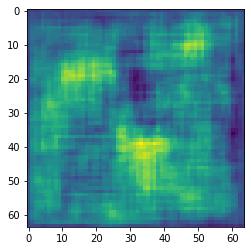

In [7]:
# Testing generator and discriminator without training
#with tpu_strategy.scope(): # Train on TPU
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS) # Create generator model
discriminator = build_discriminator(IMAGE_SIZE) # Create discriminator model
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

# Discriminate the generated image
decision = discriminator(generated_image)

# Print the discriminator decision
print(decision)

In [0]:
# Print a summary of the generator model
generator.summary()
tf.keras.utils.plot_model(generator, to_file="generator.png", show_shapes=True)

In [0]:
# Print a summary of the discriminator model
discriminator.summary()
tf.keras.utils.plot_model(discriminator, to_file="discriminator.png", show_shapes=True)

In [0]:
"""checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)"""

## Training

In [0]:
fixed_seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

In [0]:
@tf.function
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model.predict(test_input)

  plt.imshow(predictions[0, :, :, 0])

  """fig = plt.figure(figsize=(BATCH_SIZE/8, BATCH_SIZE/8))

  for i in range(predictions.shape[0]):
      plt.subplot(BATCH_SIZE/8, BATCH_SIZE/8, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()"""

@tf.function
def save_images(cnt, noise):
  print("one")
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  print("two")

  generated_images = generator.predict(noise)

  print("three")

  generated_images = 0.5 * generated_images + 0.5

  print("4")

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

  print("5")
          
  output_path = os.path.join("",'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  print("6")

  filename = os.path.join(output_path,f"train-{cnt+1}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

#@tf.function
def train_step(iterator):
  def step_fn(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(seed, training=True)

      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return gradients_of_generator,gradients_of_discriminator
  return step_fn(iterator)
  # return tpu_strategy.run(step_fn, args=(next(iterator),))

  """ 
  is_empty = False
  i = 1
  while not is_empty:
    try:
      item = next(iterator)
    except StopIteration:
      is_empty = True
    else:
      print(i)
      i = i + 1
      #"""

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print("Epoch",epoch + 1)
    start = time.time()

    i = 1
    for batch in dataset:
      print("Batch", i)
      i = i + 1
      train_step(batch)

    #save_images(epoch,fixed_seed)

    #print(f'Epoch {epoch+1}, gen loss={losses[0]},disc loss={losses[2]}, {time.time()-start}') 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # display.clear_output(wait=True)
  # generate_and_save_images(generator, epochs, fixed_seed)

In [0]:
train(dataset,EPOCHS)

In [0]:
# Generate a random image
generated_image = generator(fixed_seed, training=False)

# Plot the generated image
plt.imshow(generated_image[0, :, :, 0]) 